In [20]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import matplotlib.pyplot as plt
import os


def data_preprocessing(data, seq_length):

    # 데이터 다운로드 및 로드
    url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
    df = pd.read_csv(url, usecols=[1])  # 승객 수 컬럼만 사용
    data = df.values.astype('float32')  # NumPy 배열로 변환

    # 데이터 정규화
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_normalized = scaler.fit_transform(data)

    # 시퀀스 생성 함수
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length])
            y.append(data[i+seq_length])
        return np.array(X), np.array(y)

    X, y = create_sequences(data_normalized, seq_length)

    # 차원 변환: (샘플수, 시퀀스길이, 특성수)
    X = X.reshape(-1, seq_length, 1)
    y = y.reshape(-1, 1)

    # 텐서 변환 및 DataLoader 준비
    X_tensor = torch.from_numpy(X).float()
    y_tensor = torch.from_numpy(y).float()

    dataset = TensorDataset(X_tensor, y_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return loader, scaler

In [21]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [22]:
def main():
    seq_length = 12
    batch_size = 16

    data = None
    loader, scaler = data_preprocessing(data, seq_length)

    input_size = 1
    hidden_size = 50
    num_layers = 2
    output_size = 1
    learning_rate = 0.001
    num_epochs = 1000

    model = LSTMModel(input_size, hidden_size, num_layers, output_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        for inputs, targets in loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    model.eval()
    with torch.no_grad():
        predictions = model(X_tensor).squeeze().numpy()

    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
    actual = scaler.inverse_transform(y_tensor.numpy())

    plt.figure(figsize=(12,6))
    plt.plot(actual, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.legend()
    plt.title('Airline Passengers Prediction')
    filepath = os.path.join("./outputs/", "airplane-Passengers-Prediction.png")
    plt.savefig(filepath)
    plt.show()

Epoch [100/1000], Loss: 0.0029
Epoch [200/1000], Loss: 0.0023
Epoch [300/1000], Loss: 0.0002
Epoch [400/1000], Loss: 0.0029
Epoch [500/1000], Loss: 0.0002
Epoch [600/1000], Loss: 0.0015
Epoch [700/1000], Loss: 0.0004
Epoch [800/1000], Loss: 0.0012
Epoch [900/1000], Loss: 0.0014
Epoch [1000/1000], Loss: 0.0001


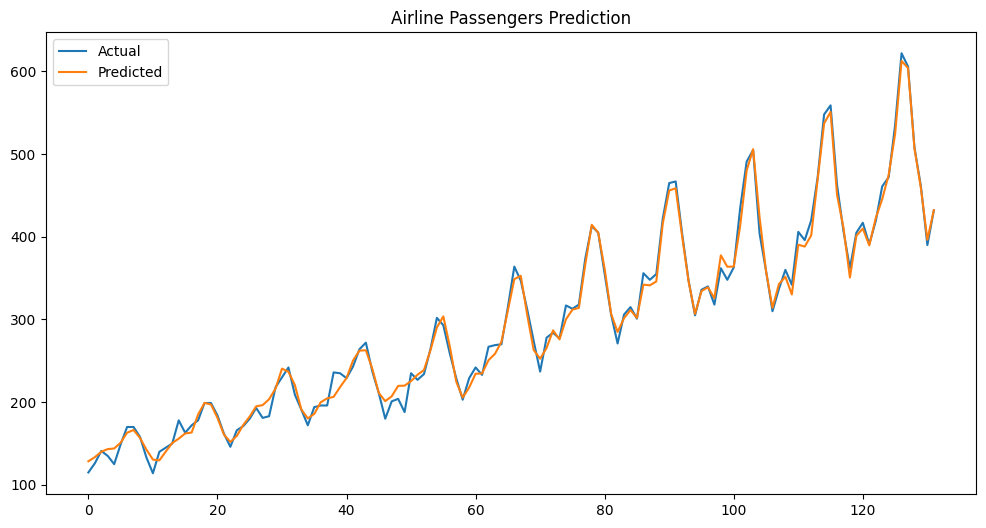

In [23]:
if __name__ == '__main__':
    main()